In [1]:
# multiclassfication 모델


- 영화리뷰데이를 가지고 한국어 사전 학습모델인 GPT2에 추가 학습을 진행
  

In [1]:
# pytorch를 이용
# 데이터 로드
# gpt2 모델 / 토크나이저 로드
# 문장을 구분하는 스페셜 토큰을 추가
# 데이셋
# 데이로드
# 학습루프
# 평가
# 추론(예측)

In [2]:
# Data  영화리뷰 데이터
import gdown

file_id = '1k-aUl9Qqg_972g6vAb1hYPQedNpp3WN9'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'test.txt', quiet=False)

file_id = '1ig2rK2OMhX1Bgz-zNNhm3aI3ZGCk3Jpl'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'train.txt', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k-aUl9Qqg_972g6vAb1hYPQedNpp3WN9
To: c:\Github\python_ML\LLM\test.txt
100%|██████████| 4.89M/4.89M [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ig2rK2OMhX1Bgz-zNNhm3aI3ZGCk3Jpl
To: c:\Github\python_ML\LLM\train.txt
100%|██████████| 14.6M/14.6M [00:00<00:00, 27.1MB/s]


'train.txt'

In [3]:
# 한국어 자연어 모델 gpt2
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AdamW
from transformers import get_linear_schedule_with_warmup
# 모델과 토크나이저 로드
MODEL_NAME = 'skt/kogpt2-base-v2'
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)  #Hugging Face 불러옴
# 패딩 토큰 설정
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # 시퀀스를 동일한 길이로 맞추기 위해서 사용
model = GPT2LMHeadModel.from_pretrained(MODEL_NAME) # 사전학습된 모델로드(전이학습)
model.resize_token_embeddings(len(tokenizer)) # 패딩토큰 추가했으니. 임배딩층 재 조정

c:\Users\Playdata\AppData\Local\anaconda3\envs\tcml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Playdata\AppData\Local\anaconda3\envs\tcml\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\Playdata\AppData\Local\anaconda3\envs\tcml\lib\site-packages\transformers\modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pick

Embedding(51202, 768)

In [5]:
!pip install pandas

  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ------------------------------------ --- 10.5/11.6 MB 65.5 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 45.3 MB/s eta 0:00:00
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [6]:
import pandas as pd
df = pd.read_csv('train.txt', sep='\t')
# sentences = df['document'].to_numpy()
len(df)


150000

- 입력데이터 형태

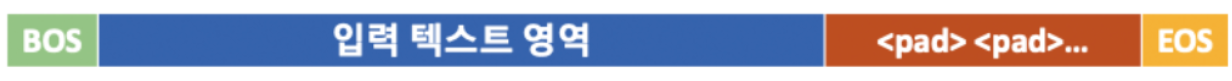

In [7]:
# 데이터셋 클래스(데이터를 읽어서 학습데이터 정답)
# 데이터 로더(배치단위)
import re
class MovieReveiwDataSet(Dataset):
  def __init__(self, dataFrame, tokenizer, max_length = 128):

    self.tokenizer = tokenizer
    self.max_length = max_length
    # 전처리 - 중복제거, - 한글만처리(정규식)
    dataFrame = dataFrame.drop_duplicates(subset=['document'])
    dataFrame = dataFrame[dataFrame['document'].notnull()]
    dataFrame['document'] = dataFrame['document'].apply(lambda x : re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]', '', x))
    self.dataFrame = dataFrame

  def __len__(self):
    return len(self.dataFrame)
  def __getitem__(self, idx):
    text = self.dataFrame.iloc[idx]['document']
    label = self.dataFrame.iloc[idx]['label']
    # 토큰화 및 패딩 - text
    inputs = self.tokenizer(text,
                   return_tensors='pt',
                   truncation=True,
                   max_length=self.max_length,
                   padding="max_length")
    inputs = {key: value.squeeze() for key, value in inputs.items()}
    # 라벨
    inputs['labels'] = torch.tensor([label]*self.max_length ,dtype=torch.long)   # [label] 라벨도 차수를 맞추기 위해서
    return inputs

dataset = MovieReveiwDataSet(df.iloc[:1000,:],tokenizer)  # 학습용데이터가 많아서 1000개만 사용
train_loader = DataLoader(dataset, batch_size=3, shuffle=True)

In [8]:
# 아 더빙.. 진짜 짜증나네요 목소리	0
#  12 11 22 11 33 12 12 12 12
#  0   0  0  0  0  0  0  0  0

for i in train_loader:
  print([v.shape for k, v in i.items()])
  break

[torch.Size([3, 128]), torch.Size([3, 128]), torch.Size([3, 128])]


In [ ]:
import torch_directml
torch_directml.device

True

In [9]:
from tqdm import tqdm
import torch_directml
# 학습
EPOCHS = 3
device = torch_directml.device() if torch_directml.is_available() else torch.device('cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# 초기에는 낮은학습률로 시작해서 점점 학습률을 높이는 방식
total_steps = len(train_loader) * EPOCHS  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(EPOCHS):
  iterator = tqdm(train_loader)
  for batch in iterator:
    # 입력데이터
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    scheduler.step()
    iterator.set_description(f"epoch: {epoch+1} / {EPOCHS} loss: {loss.item()}")

# 파인튜닝 된 모델 저장
model.save_pretrained('fine_tuned_movie_kogpt2')
tokenizer.save_pretrained('fine_tuned_movie_kogpt2')

  0%|          | 0/334 [00:00<?, ?it/s]


RuntimeError: The GPU device does not support Double (Float64) operations!

In [ ]:
# 파인튜닝된 모델과 토크나이져 로드
model = GPT2LMHeadModel.from_pretrained('fine_tuned_movie_kogpt2')
tokenizer = GPT2TokenizerFast.from_pretrained('fine_tuned_movie_kogpt2')

In [ ]:
# 평가
# 테스트로더
df = pd.read_csv('test.txt', sep='\t')
dataset = MovieReveiwDataSet(df.iloc[:1000,:],tokenizer)  # 학습용데이터가 많아서 1000개만 사용
test_loader = DataLoader(dataset, batch_size=3)

model.to(device)
total_loss = []
predictions = []
true_labels = []
with torch.no_grad():
  iterator = tqdm(test_loader)
  for batch in iterator:
    # 입력데이터
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss.append( loss.item())

    # 예측값
    logits = outputs.logits
    predictions.append(torch.argmax(logits,dim=1).cpu().numpy())
    true_labels.append(labels.cpu().numpy())

# 평가결과
# total_loss = np.mean(total_loss)
# predictions = np.concatenate(predictions, axis=0)
# true_labels = np.concatenate(true_labels, axis=0)

100%|██████████| 333/333 [00:11<00:00, 28.99it/s]


In [ ]:
import numpy as np
for pre in predictions:
  print(np.sum(pre[pre <=0.5]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
